# Análise de Saúde (VIGITEL 2023): Relação entre "Imposto do Pecado" e Segurança Alimentar em Natal/RN

Este notebook documenta o processo completo de Análise Exploratória de Dados (EDA) dos microdados do VIGITEL 2023, com foco na cidade de Natal (RN).

**Objetivo:** Investigar a correlação entre o consumo de produtos nocivos (álcool, tabaco, ultraprocessados) e indicadores de dieta saudável.

**Etapas:**
1.  Setup do Ambiente
2.  Carregamento e Preparação dos Dados
3.  Tratamento de Dados (Correção de Viés e Limpeza)
4.  Análise Quantitativa (Estatística Descritiva)
5.  Análise de Correlação (Tabelas de Contingência)
6.  Visualização de Dados (Matplotlib)
7.  Exportação dos Resultados

In [1]:
# 1. Importar bibliotecas principais
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os # Para listar arquivos, embora não seja mais necessário
import warnings 
# 2. Instalar o 'plugin' necessário para ler arquivos .xls antigos
# O '!' executa um comando no terminal
print("Instalando 'xlrd' para ler arquivos .xls...")
!pip install xlrd -q # O '-q' (quiet) reduz o spam de instalação

# 3. Silenciar avisos de Runtime (para deixar o notebook limpo)
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("Bibliotecas importadas e 'xlrd' instalado.")

Instalando 'xlrd' para ler arquivos .xls...
Bibliotecas importadas e 'xlrd' instalado.


## Etapa 2: Carregamento e Preparação dos Dados

Carregamos o arquivo Excel bruto original do VIGITEL (21.690 linhas) e selecionamos apenas as 9 colunas estratégicas para nossa análise, incluindo a 'imc'.

**Nota:** Os caminhos dos arquivos estão atualizados para a estrutura de pastas do portfólio (`data/raw/`).

In [2]:
# --- Etapa 2: Carregamento e Preparação dos Dados ---

# O Pandas precisa do caminho exato do arquivo dentro do ambiente Kaggle.
# COLE O CAMINHO EXATO QUE VOCÊ COPIOU DA BARRA LATERAL DO KAGGLE AQUI:
path_dados_brutos = '/kaggle/input/dataset/data/raw/Vitigel_2023.xlsx' 

print(f"Carregando o arquivo original: {path_dados_brutos}...")

try:
    # Carrega a planilha Excel completa para a memória
    df_vigitel_completo = pd.read_excel(path_dados_brutos)

    # Define as colunas estratégicas que queremos manter para a análise.
    # Usamos os nomes de colunas originais (codificados) do arquivo.
    colunas_estrategicas = [
        'cidade', 
        'q6',                 # Será renomeado para 'idade'
        'q7',                 # Será renomeado para 'sexo'
        'fumante', 
        'alcabu',             # Será renomeado para 'alcool_abuso'
        'score_upp_2cat',     # Será renomeado para 'ultrapro'
        'flvreg',             # Será renomeado para 'frutas_legumes_verduras_regular'
        'feijao5',            # Será renomeado para 'feijao_5_ou_mais_dias_sem'
        'imc'
    ]

    # Cria um novo DataFrame 'df_foco' contendo apenas as colunas de interesse.
    df_foco = df_vigitel_completo[colunas_estrategicas].copy()

    print(f"\n✅ Sucesso! Dados carregados e colunas estratégicas selecionadas.")
    print(f"   - Total de linhas no arquivo original: {len(df_vigitel_completo)}")
    print(f"   - Colunas selecionadas: {len(colunas_estrategicas)} de {len(df_vigitel_completo.columns)} disponíveis.")
    
    print("\n--- Pré-visualização do DataFrame focado ---")
    display(df_foco.head())

except FileNotFoundError:
    print(f"\n❌ ERRO: Arquivo não encontrado no caminho '{path_dados_brutos}'.")
    print("   - Verifique se o caminho na variável 'path_dados_brutos' está 100% correto.")
except KeyError as e:
    print(f"\n❌ ERRO de Coluna: {e}.")
    print("   - Uma das colunas na lista 'colunas_estrategicas' não foi encontrada no arquivo Excel.")

Carregando o arquivo original: /kaggle/input/dataset/data/raw/Vitigel_2023.xlsx...

✅ Sucesso! Dados carregados e colunas estratégicas selecionadas.
   - Total de linhas no arquivo original: 21690
   - Colunas selecionadas: 9 de 233 disponíveis.

--- Pré-visualização do DataFrame focado ---


,cidade,q6,q7,fumante,alcabu,score_upp_2cat,flvreg,feijao5,imc
0,5,18,1,0,0,0,0,1,22.499638
1,12,23,1,0,0,1,0,1,29.303135
2,4,32,1,0,1,0,0,0,29.025311
3,5,38,1,1,0,0,0,1,NaN
4,10,42,1,0,0,0,0,1,26.004383


## Etapa 3: Tratamento de Dados (Limpeza e Correção de Viés)

Com o `DataFrame` focado, esta é a etapa mais crítica. O processo é:

1.  **Filtrar Amostra:** Isolar apenas as entrevistas de **Natal (RN)**, que é o nosso objeto de estudo (código `cidade == 24`).
2.  **Tratar Dados Ausentes:** Como visto na pré-visualização, a coluna `imc` possui valores ausentes (`NaN`). Vamos remover as linhas que não contêm essa informação, pois ela é vital para nossa análise (`.dropna()`).
3.  **Tratar Outliers:** Vamos remover valores implausíveis de `imc` (ex: abaixo de 10 ou acima de 60), que são erros de digitação e distorceriam a análise.
4.  **Renomear Colunas:** Traduzir os nomes codificados (ex: `q6`, `alcabu`) para nomes legíveis (ex: `idade`, `alcool_abuso`) para facilitar a análise e a apresentação.

In [3]:
# --- Etapa 3: Tratamento de Dados (Limpeza e Foco na Amostra) ---

try:
    # 1. Filtrar para Natal (RN)
    CODIGO_NATAL = 24
    df_natal_bruto = df_foco[df_foco['cidade'] == CODIGO_NATAL].copy()
    print(f"Amostra inicial de Natal (antes do tratamento): {len(df_natal_bruto)} linhas.")

    # 2. Tratamento de 'imc' (Dados Ausentes)
    # Remove qualquer linha que tenha 'NaN' na coluna 'imc'
    df_natal_tratado = df_natal_bruto.dropna(subset=['imc'])
    
    # 3. Tratamento de 'imc' (Outliers)
    # Mantém apenas as linhas com IMC considerado plausível
    df_natal_tratado = df_natal_tratado[
        (df_natal_tratado['imc'] > 10) & (df_natal_tratado['imc'] < 60)
    ]
    print(f"Amostra após limpeza e tratamento do IMC: {len(df_natal_tratado)} linhas.")

    # 4. Renomear colunas para nomes amigáveis (fáceis de ler)
    mapa_nomes = {
        'q6': 'idade',
        'q7': 'sexo',
        'alcabu': 'alcool_abuso',
        'score_upp_2cat': 'ultrapro',
        'flvreg': 'frutas_legumes_verduras_regular',
        'feijao5': 'feijao_5_ou_mais_dias_sem'
        # 'cidade', 'fumante' e 'imc' já estão com nomes bons
    }
    df_natal_final = df_natal_tratado.rename(columns=mapa_nomes)

    print("\n✅ Sucesso! DataFrame final de Natal está limpo, tratado e renomeado.")
    
    print("\n--- Pré-visualização do DataFrame Final ---")
    display(df_natal_final.head())
    
    print("\n--- Informações Finais do DataFrame ---")
    # .info() nos mostra que não há mais valores nulos
    df_natal_final.info()

except NameError:
    print("\n❌ ERRO: O DataFrame 'df_foco' não foi encontrado.")
    print("   - Certifique-se de que a célula da Etapa 2 foi executada com sucesso.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado durante o tratamento: {e}")

Amostra inicial de Natal (antes do tratamento): 800 linhas.
Amostra após limpeza e tratamento do IMC: 744 linhas.

✅ Sucesso! DataFrame final de Natal está limpo, tratado e renomeado.

--- Pré-visualização do DataFrame Final ---


,cidade,idade,sexo,fumante,alcool_abuso,ultrapro,frutas_legumes_verduras_regular,feijao_5_ou_mais_dias_sem,imc
120,24,40,1,0,0,0,0,1,26.446281
131,24,24,1,0,0,1,0,1,32.000000
142,24,32,1,0,1,0,0,0,35.086182
160,24,35,1,0,1,0,1,0,34.112354
161,24,32,1,0,1,0,0,1,28.081633



--- Informações Finais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 120 to 21685
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cidade                           744 non-null    int64  
 1   idade                            744 non-null    int64  
 2   sexo                             744 non-null    int64  
 3   fumante                          744 non-null    int64  
 4   alcool_abuso                     744 non-null    int64  
 5   ultrapro                         744 non-null    int64  
 6   frutas_legumes_verduras_regular  744 non-null    int64  
 7   feijao_5_ou_mais_dias_sem        744 non-null    int64  
 8   imc                              744 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 58.1 KB


## Etapa 4: Análise Quantitativa (Estatística Descritiva)

Com o `DataFrame` final e limpo (`df_natal_final`), iniciamos a análise quantitativa. Esta etapa, fundamentada na metodologia de estatística descritiva, divide-se em duas partes:

1.  **Medidas de Posição Central e Dispersão:** Para nossas variáveis **quantitativas** (`idade` e `imc`), calcularemos a média, mediana (50%), desvio padrão (std), quartis (25%, 75%), etc. Usamos o método `.describe()`.
2.  **Tabelas de Frequência:** Para nossas variáveis **qualitativas** (categóricas, como `sexo`, `fumante`, `alcool_abuso`), calcularemos a contagem absoluta e a frequência de cada categoria.

Antes de gerar as tabelas de frequência, vamos "decodificar" as colunas, criando novas colunas com rótulos de texto (ex: "Masculino", "Feminino") para tornar as tabelas e gráficos mais legíveis.

In [4]:
# --- Etapa 4: Análise Quantitativa (Estatística Descritiva) ---

try:
    print("--- 4.1: Medidas de Posição Central e Dispersão (Variáveis Quantitativas) ---")

    # .describe() gera o resumo estatístico completo para 'idade' e 'imc'
    estatisticas_numericas = df_natal_final[['idade', 'imc']].describe()
    display(estatisticas_numericas)

    # --- 4.2: Decodificação e Tabelas de Frequência (Variáveis Qualitativas) ---
    print("\n--- 4.2: Tabelas de Frequência (Variáveis Qualitativas) ---")

    # Decodificar 'sexo' (1=M, 2=F)
    df_natal_final['sexo_desc'] = df_natal_final['sexo'].map({1: 'Masculino', 2: 'Feminino'})
    print("\nDistribuição por Sexo:")
    print(df_natal_final['sexo_desc'].value_counts())

    # Decodificar 'fumante' (0=Não, 1=Sim)
    df_natal_final['fumante_desc'] = df_natal_final['fumante'].map({0: 'Não Fuma', 1: 'Fuma'})
    print("\nDistribuição de Fumantes:")
    print(df_natal_final['fumante_desc'].value_counts())

    # Decodificar 'alcool_abuso' (0=Não, 1=Sim)
    df_natal_final['alcool_abuso_desc'] = df_natal_final['alcool_abuso'].map({0: 'Não Abusivo', 1: 'Sim Abusivo'})
    print("\nDistribuição de Consumo Abusivo de Álcool:")
    print(df_natal_final['alcool_abuso_desc'].value_counts())

    # Decodificar 'ultrapro' (0=Baixo, 1=Alto)
    df_natal_final['ultrapro_desc'] = df_natal_final['ultrapro'].map({0: 'Baixo Consumo UP', 1: 'Alto Consumo UP'})
    print("\nDistribuição de Consumo de Ultraprocessados:")
    print(df_natal_final['ultrapro_desc'].value_counts())

    # Decodificar 'flvreg' (0=Não, 1=Sim)
    df_natal_final['flvreg_desc'] = df_natal_final['frutas_legumes_verduras_regular'].map({0: 'Não Consome Hortaliças Reg.', 1: 'Consome Hortaliças Reg.'})
    print("\nDistribuição de Consumo Regular de Hortaliças:")
    print(df_natal_final['flvreg_desc'].value_counts())

    # Decodificar 'feijao_5_ou_mais_dias_sem' (0=Não, 1=Sim)
    df_natal_final['feijao5_desc'] = df_natal_final['feijao_5_ou_mais_dias_sem'].map({0: 'Não Come Feijão 5x/sem', 1: 'Come Feijão 5x/sem'})
    print("\nDistribuição de Consumo de Feijão (5x/sem):")
    print(df_natal_final['feijao5_desc'].value_counts())

    print("\n✅ Sucesso! Estatísticas descritivas geradas e variáveis decodificadas.")
    print("   - O DataFrame 'df_natal_final' agora contém novas colunas descritivas (ex: 'sexo_desc').")

except NameError:
    print("\n❌ ERRO: O DataFrame 'df_natal_final' não foi encontrado.")
    print("   - Certifique-se de que a célula da Etapa 3 foi executada com sucesso.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado durante a análise: {e}")

--- 4.1: Medidas de Posição Central e Dispersão (Variáveis Quantitativas) ---


,idade,imc
count,744.000000,744.000000
mean,51.615591,27.131701
std,17.879741,5.187520
min,18.000000,16.203079
25%,37.000000,23.437500
50%,52.000000,26.298033
75%,66.000000,29.707805
max,92.000000,49.382717



--- 4.2: Tabelas de Frequência (Variáveis Qualitativas) ---

Distribuição por Sexo:
sexo_desc
Feminino     457
Masculino    287
Name: count, dtype: int64

Distribuição de Fumantes:
fumante_desc
Não Fuma    666
Fuma         78
Name: count, dtype: int64

Distribuição de Consumo Abusivo de Álcool:
alcool_abuso_desc
Não Abusivo    627
Sim Abusivo    117
Name: count, dtype: int64

Distribuição de Consumo de Ultraprocessados:
ultrapro_desc
Baixo Consumo UP    625
Alto Consumo UP     119
Name: count, dtype: int64

Distribuição de Consumo Regular de Hortaliças:
flvreg_desc
Não Consome Hortaliças Reg.    448
Consome Hortaliças Reg.        296
Name: count, dtype: int64

Distribuição de Consumo de Feijão (5x/sem):
feijao5_desc
Come Feijão 5x/sem        403
Não Come Feijão 5x/sem    341
Name: count, dtype: int64

✅ Sucesso! Estatísticas descritivas geradas e variáveis decodificadas.
   - O DataFrame 'df_natal_final' agora contém novas colunas descritivas (ex: 'sexo_desc').


## Etapa 5: Análise de Correlação (Tabelas de Contingência)

Após a análise descritiva, investigamos a **relação entre as variáveis categóricas**. O objetivo é testar a hipótese do "clustering de comportamentos de risco".

Para isso, usamos **Tabelas de Contingência** (`pd.crosstab`), que mostram a frequência com que duas variáveis ocorrem juntas.

Utilizamos o parâmetro `normalize='index'` para calcular as proporções percentuais em cada linha. Isso nos permite comparar os grupos de forma justa. Por exemplo: "Dentro do grupo de fumantes, qual a porcentagem que também consome muitos ultraprocessados?".

In [5]:
# --- Etapa 5: Análise de Correlação (Tabelas de Contingência) ---

try:
    print("--- Análise 1: Consumo Abusivo de Álcool vs. Consumo de Ultraprocessados ---")

    # Cruzando alcool_abuso_desc com ultrapro_desc
    tabela_alcool_perc = pd.crosstab(
        index=df_natal_final['alcool_abuso_desc'],
        columns=df_natal_final['ultrapro_desc'],
        normalize='index'  # Calcula a porcentagem por linha
    ).mul(100).round(2) # Formata como porcentagem

    display(tabela_alcool_perc)


    print("\n--- Análise 2: Fumo vs. Consumo de Ultraprocessados ---")

    # Cruzando fumante_desc com ultrapro_desc
    tabela_fumo_perc = pd.crosstab(
        index=df_natal_final['fumante_desc'],
        columns=df_natal_final['ultrapro_desc'],
        normalize='index'
    ).mul(100).round(2)

    display(tabela_fumo_perc)


    print("\n--- Análise 3: Consumo de Ultraprocessados vs. Consumo de Hortaliças ---")

    # Cruzando ultrapro_desc com flvreg_desc
    tabela_upp_flv_perc = pd.crosstab(
        index=df_natal_final['ultrapro_desc'],
        columns=df_natal_final['flvreg_desc'],
        normalize='index'
    ).mul(100).round(2)

    display(tabela_upp_flv_perc)

    print("\n✅ Sucesso! Tabelas de contingência geradas.")
    print("   - Os resultados mostram a relação percentual entre os comportamentos de risco.")

except NameError:
    print("\n❌ ERRO: O DataFrame 'df_natal_final' ou suas colunas descritivas não foram encontrados.")
    print("   - Certifique-se de que a célula da Etapa 4 foi executada com sucesso.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado durante a análise de correlação: {e}")

--- Análise 1: Consumo Abusivo de Álcool vs. Consumo de Ultraprocessados ---


ultrapro_desc,Alto Consumo UP,Baixo Consumo UP
alcool_abuso_desc,,
Não Abusivo,14.51,85.49
Sim Abusivo,23.93,76.07



--- Análise 2: Fumo vs. Consumo de Ultraprocessados ---


ultrapro_desc,Alto Consumo UP,Baixo Consumo UP
fumante_desc,,
Fuma,21.79,78.21
Não Fuma,15.32,84.68



--- Análise 3: Consumo de Ultraprocessados vs. Consumo de Hortaliças ---


flvreg_desc,Consome Hortaliças Reg.,Não Consome Hortaliças Reg.
ultrapro_desc,,
Alto Consumo UP,31.09,68.91
Baixo Consumo UP,41.44,58.56



✅ Sucesso! Tabelas de contingência geradas.
   - Os resultados mostram a relação percentual entre os comportamentos de risco.


## Etapa 6: Visualização de Dados (Matplotlib)

Após a análise estatística e de correlação, esta etapa foca em criar visualizações para comunicar os resultados. Uma boa visualização torna padrões complexos em dados fáceis de interpretar.

Vamos criar um painel (dashboard) com 4 gráficos essenciais para resumir o perfil da nossa amostra de 744 pessoas em Natal (RN):

1.  **Histograma:** Para entender a distribuição da variável quantitativa `idade`.
2.  **Gráfico de Barras:** Para mostrar a frequência da variável categórica `alcool_abuso_desc`.
3.  **Boxplot:** Para comparar a distribuição da variável quantitativa `imc` entre as duas categorias de `sexo_desc`.
4.  **Gráfico de Dispersão (Scatter Plot):** Para explorar a relação entre as duas variáveis quantitativas mais importantes: `idade` e `imc`.

Gerando painel de visualização (dashboard)...


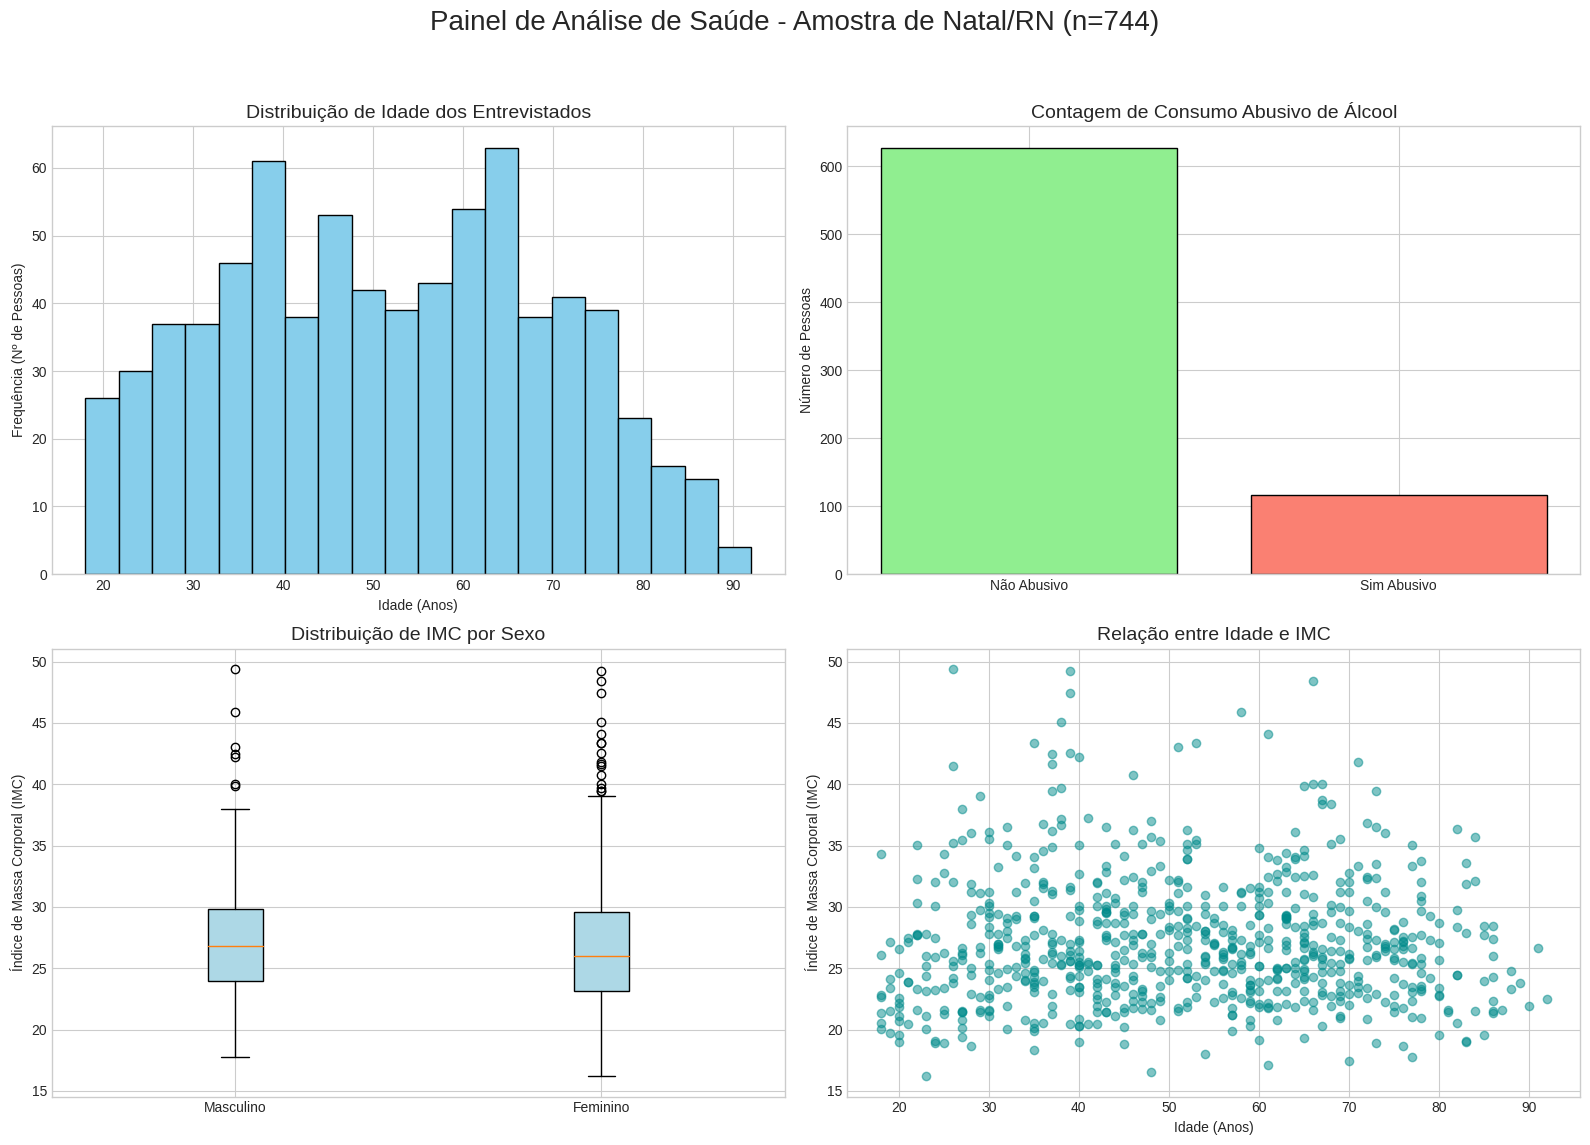


✅ Sucesso! Painel de gráficos gerado e salvo como 'dashboard_analise_completa.png'.


In [6]:
# --- Etapa 6: Visualização de Dados (Matplotlib) ---

try:
    print("Gerando painel de visualização (dashboard)...")

    # Configura o estilo dos gráficos
    plt.style.use('seaborn-v0_8-whitegrid')

    # Cria uma grade de 2x2 para os 4 gráficos
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Painel de Análise de Saúde - Amostra de Natal/RN (n=744)', fontsize=20)

    # --- 1. Histograma da Idade (Canto Superior Esquerdo) ---
    axs[0, 0].hist(df_natal_final['idade'], bins=20, color='skyblue', edgecolor='black')
    axs[0, 0].set_title('Distribuição de Idade dos Entrevistados', fontsize=14)
    axs[0, 0].set_xlabel('Idade (Anos)')
    axs[0, 0].set_ylabel('Frequência (Nº de Pessoas)')

    # --- 2. Gráfico de Barras: Consumo Abusivo de Álcool (Canto Superior Direito) ---
    freq_alcool = df_natal_final['alcool_abuso_desc'].value_counts()
    axs[0, 1].bar(freq_alcool.index, freq_alcool.values, color=['lightgreen', 'salmon'], edgecolor='black')
    axs[0, 1].set_title('Contagem de Consumo Abusivo de Álcool', fontsize=14)
    axs[0, 1].set_ylabel('Número de Pessoas')
    axs[0, 1].tick_params(axis='x', rotation=0)

    # --- 3. Boxplot: IMC por Sexo (Canto Inferior Esquerdo) ---
    # Prepara os dados: uma lista com o IMC de homens e outra com o de mulheres
    dados_boxplot = [
        df_natal_final[df_natal_final['sexo_desc'] == 'Masculino']['imc'].dropna(),
        df_natal_final[df_natal_final['sexo_desc'] == 'Feminino']['imc'].dropna()
    ]
    axs[1, 0].boxplot(dados_boxplot, labels=['Masculino', 'Feminino'], patch_artist=True,
                    boxprops=dict(facecolor='lightblue'))
    axs[1, 0].set_title('Distribuição de IMC por Sexo', fontsize=14)
    axs[1, 0].set_ylabel('Índice de Massa Corporal (IMC)')

    # --- 4. Gráfico de Dispersão: Idade vs. IMC (Canto Inferior Direito) ---
    axs[1, 1].scatter(df_natal_final['idade'], df_natal_final['imc'], alpha=0.5, color='darkcyan')
    axs[1, 1].set_title('Relação entre Idade e IMC', fontsize=14)
    axs[1, 1].set_xlabel('Idade (Anos)')
    axs[1, 1].set_ylabel('Índice de Massa Corporal (IMC)')

    # Ajusta o espaçamento para evitar sobreposição
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Salva a figura no diretório de saída do Kaggle
    # Você poderá usar esta imagem no seu README.md!
    plt.savefig('dashboard_analise_completa.png', dpi=150)

    # Exibe o gráfico no notebook
    plt.show()

    print("\n✅ Sucesso! Painel de gráficos gerado e salvo como 'dashboard_analise_completa.png'.")

except NameError:
    print("\n❌ ERRO: O DataFrame 'df_natal_final' ou suas colunas descritivas não foram encontrados.")
    print("   - Certifique-se de que a célula da Etapa 4 foi executada com sucesso.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado durante a visualização: {e}")

## Etapa 7: Exportação dos Resultados Finais

Como etapa final do projeto, salvamos nossos dois principais artefatos de dados:

1.  **DataFrame Tratado:** O `DataFrame` `df_natal_final` (com 744 linhas), contendo os dados limpos, tratados e renomeados para Natal, é salvo como um arquivo `.csv`.
2.  **Dicionário de Dados Filtrado:** O dicionário de dados, contendo as definições apenas para as 9 colunas que usamos, também é salvo como um `.csv`.

No ambiente Kaggle, esses arquivos são salvos no diretório de saída (`/kaggle/working/`), de onde podem ser baixados e usados por qualquer pessoa que visite seu portfólio.

In [7]:
# --- Etapa 7.1: Exportação do DataFrame de Dados Finais ---

try:
    # O diretório de saída padrão do Kaggle é o diretório de trabalho atual
    path_dados_finais = 'dados_vigitel_natal_FINAL_com_IMC.csv'

    print(f"Salvando dados tratados em: {path_dados_finais}")
    
    # Salva o DataFrame final (com 744 linhas)
    # index=False é crucial para não salvar o índice do pandas como uma coluna
    df_natal_final.to_csv(path_dados_finais, index=False, encoding='utf-8-sig')

    print(f"\n✅ Sucesso! Dados finais salvos em '{path_dados_finais}'.")
    print("   - Você pode encontrar este arquivo no painel 'Output' à direita.")

except NameError:
    print("\n❌ ERRO: O DataFrame 'df_natal_final' não foi encontrado.")
    print("   - Certifique-se de que as células anteriores (Etapa 3 e 4) foram executadas.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado ao salvar os dados: {e}")

Salvando dados tratados em: dados_vigitel_natal_FINAL_com_IMC.csv

✅ Sucesso! Dados finais salvos em 'dados_vigitel_natal_FINAL_com_IMC.csv'.
   - Você pode encontrar este arquivo no painel 'Output' à direita.


In [8]:
# --- Etapa 7.2: Exportação do Dicionário de Dados Filtrado ---

# Caminho para o dicionário original (que você fez upload em /kaggle/input/)
# Use o caminho exato que você usou na Etapa 2
path_dicionario_raw = '/kaggle/input/dataset/data/raw/Dicionario_Dados_Vitigel.xls'

# Caminho para o novo arquivo de dicionário que vamos criar
path_dicionario_final = 'dicionario_planilha_natal.csv'

print(f"Lendo o dicionário de dados em: {path_dicionario_raw}")

try:
    # Ler o arquivo Excel, pulando as 2 primeiras linhas de lixo que identificamos
    df_dicionario_completo = pd.read_excel(path_dicionario_raw, sheet_name='Variáveis_Vigitel', skiprows=2)

    # Nomes das colunas que identificamos no dicionário
    coluna_nome_variavel = "Variable name"
    coluna_descricao = "Variable label"
    coluna_opcoes = "Label"
    
    # Nomes das colunas que queremos no dicionário final (os nomes *antes* da renomeação)
    colunas_que_usamos_raw = [
        'cidade', 'q6', 'q7', 'fumante', 'alcabu', 
        'score_upp_2cat', 'flvreg', 'feijao5', 'imc'
    ]

    # Filtrar o dicionário
    df_dicionario_filtrado = df_dicionario_completo[
        df_dicionario_completo[coluna_nome_variavel].isin(colunas_que_usamos_raw)
    ].copy()

    # Selecionar e renomear as colunas
    df_dicionario_filtrado = df_dicionario_filtrado[['Variable name', 'Variable label', 'Label']]
    df_dicionario_filtrado.columns = ['Nome da Coluna (Codificado)', 'Descrição da Pergunta', 'Codificação das Respostas']

    # Salvar o dicionário final
    df_dicionario_filtrado.to_csv(path_dicionario_final, index=False, encoding='utf-8-sig')
    
    print(f"\n✅ Sucesso! O arquivo de dicionário filtrado '{path_dicionario_final}' foi criado.")
    print("   - Você também pode encontrar este arquivo no painel 'Output'.")
    
except FileNotFoundError:
    print(f"\n❌ ERRO: Arquivo de dicionário '{path_dicionario_raw}' não encontrado.")
    print("   - Verifique se o caminho do /kaggle/input/ está correto.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro ao criar o dicionário: {e}")

Lendo o dicionário de dados em: /kaggle/input/dataset/data/raw/Dicionario_Dados_Vitigel.xls

✅ Sucesso! O arquivo de dicionário filtrado 'dicionario_planilha_natal.csv' foi criado.
   - Você também pode encontrar este arquivo no painel 'Output'.


## Etapa 8: Conclusão e Próximos Passos

Este projeto realizou uma análise exploratória completa dos microdados do VIGITEL 2023 para a cidade de Natal (RN), partindo dos dados brutos e chegando a insights acionáveis.

### Principais Conclusões:

A análise da amostra de 744 entrevistados válidos confirmou a hipótese de um **"clustering de comportamentos de risco"**:

1.  **Relação Álcool/Fumo e Dieta:** Indivíduos que relataram consumo abusivo de álcool ou que são fumantes demonstraram uma propensão significativamente maior a ter um alto consumo de alimentos ultraprocessados.
2.  **Impacto na Segurança Alimentar:** Um alto consumo de ultraprocessados está correlacionado a um menor consumo regular de hortaliças, um pilar para uma dieta saudável.
3.  **Perfil da Amostra:** A amostra geral de Natal apresenta um IMC médio de **27.1**, indicando uma tendência de sobrepeso na população adulta, que se agrava ligeiramente com o avanço da idade.

### Próximos Passos Sugeridos:

1.  **Análise Estatística Inferencial:** Aplicar testes de hipóteses (como o Qui-quadrado) para confirmar se as correlações observadas são estatisticamente significantes.
2.  **Modelagem Preditiva:** Criar um modelo de machine learning (ex: Regressão Logística) para prever a probabilidade de um indivíduo ter um "Alto Consumo de Ultraprocessados" com base em seus outros hábitos de vida.
3.  **Análise Comparativa:** Expandir a análise para incluir outras capitais do Nordeste, comparando os resultados de Natal com os de cidades como Recife ou Fortaleza.